In [1]:
!pip install pydicom

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 7.7 MB/s eta 0:00:00


In [2]:
!pip install pyradiomics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 34.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
Discarding https://files.pythonhosted.org/packages/03/c1/20fc2c50ab1e3304da36d866042a1905a2b05a1431ece35448ab6b4578f2/pyradiomics-3.1.0.tar.gz (from https://pypi.org/simple/pyradiomics/): Requested pyradiomics from https://files.pythonhosted.org/packages/03/c1/20fc2c50ab1e3304da36d866042a1905a2b05a1431ece35448ab6b4578f2/pyradiomics-3.1.0.tar.gz has inconsistent version: expected '3.1.0', but metadata has '3.0.1a1'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 28.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 9.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.8/117.8 kB 11.3 MB/s eta 0:00:

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from pydicom import dcmread
import glob
import radiomics
from radiomics import featureextractor, getTestCase
import SimpleITK as sitk
import os

from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA

from sklearn.model_selection import KFold, train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, adjusted_rand_score
from sklearn.metrics import RocCurveDisplay, auc
from sklearn.preprocessing import StandardScaler

from scipy.stats import mode
import scipy.stats as stats

import random

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Find the paths and visualization

In [6]:
path = "/content/drive/MyDrive/Healthcare/"  # CHANGE WITH YOUR PATH

malignant = []
malignant_masks = []
benign = []
benign_masks = []

malignant = sorted(glob.glob(path + "malignant/*).png"))
malignant_masks = sorted(glob.glob(path + "malignant/*_mask.png"))
benign = sorted(glob.glob(path + "benign/*).png"))
benign_masks = sorted(glob.glob(path + "benign/*_mask.png"))


In [7]:
# Some images have multiple masks, let's deal with that

def dupeIdx(dupe_masks):
  '''
  extract the indices from images with multiple masks
  '''
  idxs = []
  for path in dupe_masks:
      idxs.append(path.split("(")[1].split(")")[0])
  return idxs

def pathMatcher(idxs, paths):
  '''
  match the indices of the extra masks with the relative img
  '''
  b_to_dup = []
  for idx in idxs:
      for path in paths:
          if path.split("(")[1].split(")")[0]==idx:
              b_to_dup.append(path)
  return b_to_dup

m_dup_masks = sorted(glob.glob(path + "malignant/*_mask_*.png"))
b_dup_masks = sorted(glob.glob(path + "benign/*_mask_*.png"))

m_dup_paths = pathMatcher(dupeIdx(m_dup_masks), malignant)
b_dup_paths = pathMatcher(dupeIdx(b_dup_masks), benign)

# Let's add both at the end of the path lists

malignant_masks.extend(m_dup_masks)
malignant.extend(m_dup_paths)
benign_masks.extend(b_dup_masks)
benign.extend(b_dup_paths)

In [8]:
print(f'\033[92m')
print('N° of malignant samples:',len(malignant))
print('N° of malignant masks:',len(malignant_masks))
print('N° of benign samples::',len(benign))
print('N° of benign masks::',len(benign_masks))


N° of malignant samples: 182
N° of malignant masks: 182
N° of benign samples:: 356
N° of benign masks:: 356


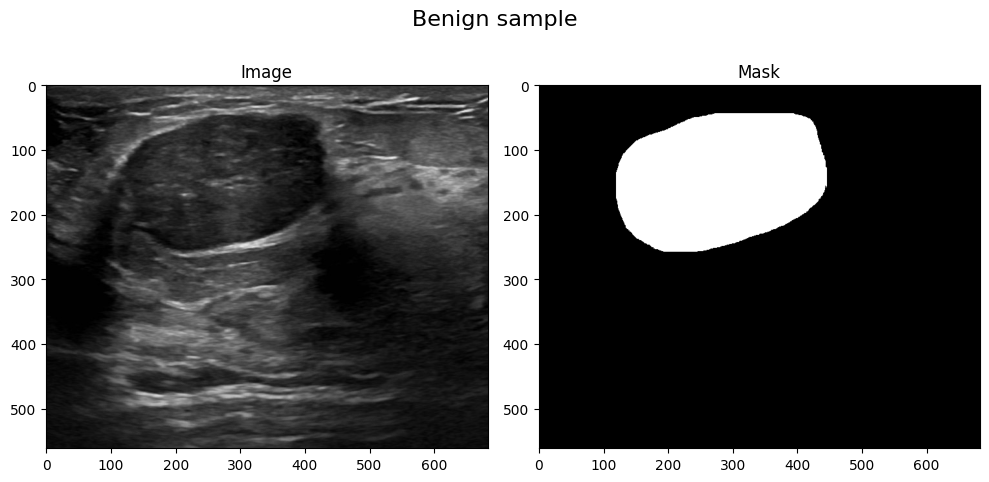

In [9]:
# Visualize an example

idx = np.random.randint(0,356)
img = sitk.ReadImage(benign[idx], sitk.sitkFloat32)
msk = sitk.ReadImage(benign_masks[idx], sitk.sitkFloat32)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(sitk.GetArrayFromImage(img), cmap='gray')
axes[0].set_title('Image')
axes[1].imshow(sitk.GetArrayFromImage(msk), cmap='gray')
axes[1].set_title('Mask')

fig.suptitle('Benign sample', fontsize=16)
plt.tight_layout()
plt.show()

## Functions

### Radiomic Features

Various features can be extracted using PyRadiomics, they are subdivided into the following classes:
- First Order Statistics (19 features): 'firstorder'
- Shape-based (3D) (16 features): 'shape'                    
- Shape-based (2D) (10 features): 'shape2D'
  
- Gray Level Co-occurrence Matrix (24 features): 'glcm'  (GLCM symmetrical warning)
- Gray Level Run Length Matrix (16 features): 'glrlm'
- Gray Level Size Zone Matrix (16 features): 'glszm'
- Neighbouring Gray Tone Difference Matrix (5 features): 'ngtdm'
- Gray Level Dependence Matrix (14 features): 'gldm'

Note that in this task we are interested only in 2D ones.

_NB:_
Almost every OrderedDict generated by the extractor with different features has different lenght, however it's usually made out of 21/22 diagnostics masks and then the actual features are reported. This could be usefull for some iterations

We can filter the features we're interested in with: \
\
_first_order_features = {key: value.item() for key, value in features.items() if key.startswith('original_')}_ \
\
However, firstorder and shape2D appear to miss one feature!

After double checking with the documentation we found out that the one missing in firstorder is standard deviation! that's quite useless as we already have variance anyways.
In shape2D the one missing is Spherical Disproportion, that's not enabled by default as correlated to Sphericity.

To include those features in the extraction, specify them by name in the enabled features, however, we are clearly not interested in correlated features.

In [10]:
# This function gets as inputs two lists of images and masks, and the list of radiomic features
# we are interested in, it returns a dataset with the features of the whole images.

def featurex(image_paths, mask_paths, ftype):
  df = pd.DataFrame()
  for feat in ftype:
    features_list = []
    # Define the feature extractor we're going to employ
    extractor = featureextractor.RadiomicsFeatureExtractor()
    extractor.disableAllFeatures()
    extractor.enableFeatureClassByName(feat)

    # iterates over the image-mask pairs, extracts the features we are interested in
    # and ignores the diagnostic statistics, appends them in a list
    for image_path, mask_path in zip(image_paths, mask_paths):
        img = sitk.ReadImage(image_path, sitk.sitkFloat32)
        msk = sitk.ReadImage(mask_path, sitk.sitkUInt8)
        features = extractor.execute(img, msk, label=255)
        og_features = {key: value.item() for key, value in features.items() if key.startswith('original_')}
        features_list.append(og_features)

    # convert the list in a pd.DataFrame and returns it
    curr_df = pd.DataFrame(features_list)
    df = pd.concat([df, curr_df], axis=1)
  return df

With this function we lose the paths of the images, we might want to save them as well for some representations

### Metrics

In [11]:
# Definitions of the metrics

def TP(prediction:list, test:list)->int:                                 # considering 1 as positive class
     count = 0
     for x in range(len(prediction)):
         if prediction[x]==test[x] and test[x]==1:
             count+=1
     return count

def TN(prediction:list, test:list)->int:                                 # considering 0 as negative class
    count = 0
    for x in range(len(prediction)):
        if prediction[x]==test[x] and test[x]==0:
            count+=1
    return count

def accuracy(prediction:list, test:list)->int:                           # (TP+TN) / n
    return round((TP(prediction, test)+TN(prediction,test))/len(test),3)

def sensitivity(prediction:list, test:list)->int:                        # TP / TP + FN
    return round(TP(prediction, test)/test.count(1),3)

def specificity(prediction:list, test:list)->int:                        # TN / TN + FP
    return round(TN(prediction, test)/test.count(0),3)


def ci(mean, std, n):                                                    # 95% confidence interval
    z = stats.norm.ppf(0.975)
    margin_of_error = z * (std / (n ** 0.5))
    lower_bound = round((mean - margin_of_error), 3)
    upper_bound = round((mean + margin_of_error), 3)

    return lower_bound, upper_bound

## Select radiomics features

Now we'll experiment with various radiomic features and models to determine which combination is best suited for our task.

### Fist-order features

In [ ]:
malignant_features = featurex(malignant, malignant_masks, ["firstorder"])
benign_features = featurex(benign, benign_masks, ["firstorder"])

### Shape2D features

In [ ]:
malignant_features = featurex(malignant, malignant_masks, ["shape2D"])
benign_features = featurex(benign, benign_masks, ["shape2D"])

INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 255
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Computing shape2D
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Calculating 

### All features

In [12]:
malignant_features = featurex(malignant, malignant_masks, ["firstorder","shape2D","glcm", "gldm", "glrlm", "glszm", "ngtdm"])
benign_features = featurex(benign, benign_masks, ["firstorder","shape2D","glcm", "gldm", "glrlm", "glszm", "ngtdm"])

# We drop SumAverage because it's 2*JointAverage (which we have already saved)
malignant_features = malignant_features.drop(["original_glcm_SumAverage"],axis=1)
benign_features = benign_features.drop(["original_glcm_SumAverage"],axis=1)

Output streaming troncato alle ultime 5000 righe.
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Calculating features with label: 255
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Calculating features with label: 255
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextract

## Manipulation of the dataset

For the normalization we can:
- Z-score normalize the class individually before concatenating the dataframe
- Z-score normalize the entire dataframe before train-test splitting
- Z-score normalize separatly the train and test set (more accurate and unbiased)
  on new, unseen data, we can both perform a normalization based on our training mean and std
  or using the new data mean and std

In [ ]:
# 1. Z-score Normalization individual class

'''
mal_mean = malignant_features.mean()
mal_std = malignant_features.std()
ben_mean = benign_features.mean()
ben_std = benign_features.std()

malignant_features = (malignant_features - mal_mean)/mal_std
benign_features = (benign_features - ben_mean)/ben_std
'''

In [13]:
# let's add the target variable before concatenating the two dfs
# - 1: malignant tumor
# - 0: benign tumor

malignant_features["tumor"] = 1
benign_features["tumor"] = 0

df = pd.concat([malignant_features, benign_features], ignore_index=True)
df = df.sample(frac=1).reset_index(drop=True) #this shuffles the dataset

In [14]:
df.sample(3)

,original_firstorder_10Percentile,original_firstorder_90Percentile,original_firstorder_Energy,original_firstorder_Entropy,original_firstorder_InterquartileRange,original_firstorder_Kurtosis,original_firstorder_Maximum,original_firstorder_MeanAbsoluteDeviation,original_firstorder_Mean,original_firstorder_Median,...,original_glszm_SmallAreaLowGrayLevelEmphasis,original_glszm_ZoneEntropy,original_glszm_ZonePercentage,original_glszm_ZoneVariance,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength,tumor
150,18.0,132.0,14994976.0,2.500662,45.0,4.632149,208.0,33.386973,56.685121,43.0,...,0.002053,5.013858,0.015571,3.388022e+04,6.737524,0.009996,7.113301,0.017727,0.500058,0
215,1.0,76.0,124750531.0,1.681554,38.0,5.936672,196.0,26.888187,25.573746,8.0,...,0.050026,6.764943,0.003916,7.122289e+06,81.306082,0.000972,2.518325,0.004661,0.044229,1
461,1.0,57.0,67383217.0,1.384816,28.0,7.829021,216.0,18.112869,22.675254,15.0,...,0.049994,6.300167,0.004758,6.181176e+06,65.797926,0.000858,3.750337,0.001728,0.079764,0


In [ ]:
# 2. Z-score on entire df

'''
y = df["tumor"]
X = df.drop(['tumor'], axis=1)

scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

df = pd.DataFrame(X_normalized, columns=X.columns)
df['tumor'] = y
'''


In [15]:
# Train-Test split

rs = 42
y = df["tumor"]
X = df.drop(['tumor'], axis=1)

X_train, X_score, y_train, y_score = train_test_split(X, y, test_size=0.3, stratify=y, random_state=rs)

In [16]:
# 3. Z-score normalization on respective subsets

scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)
X_score = pd.DataFrame(scaler.fit_transform(X_score), columns = X_score.columns)

In [17]:
X_train.sample(3)

,original_firstorder_10Percentile,original_firstorder_90Percentile,original_firstorder_Energy,original_firstorder_Entropy,original_firstorder_InterquartileRange,original_firstorder_Kurtosis,original_firstorder_Maximum,original_firstorder_MeanAbsoluteDeviation,original_firstorder_Mean,original_firstorder_Median,...,original_glszm_SmallAreaHighGrayLevelEmphasis,original_glszm_SmallAreaLowGrayLevelEmphasis,original_glszm_ZoneEntropy,original_glszm_ZonePercentage,original_glszm_ZoneVariance,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength
166,0.399994,-0.043016,-0.632306,-0.028162,-0.510831,1.018690,1.244637,-0.228464,0.052191,-0.128885,...,2.189022,0.303259,-0.970290,2.013891,-0.153782,-0.820413,1.624827,2.059982,-0.104315,4.897044
277,-0.511508,-1.073676,-0.587176,-0.540159,-0.895608,0.295453,-0.598704,-1.051899,-0.887030,-0.866865,...,-0.042609,-0.245960,-0.472732,-0.664522,-0.117848,-0.413721,-0.264929,-0.532117,-0.564954,-0.056730
367,-1.119175,-0.803741,-0.613060,-0.491290,-0.181022,0.306929,0.149318,-0.011170,-1.077041,-1.082109,...,1.352364,-0.290858,-0.718687,-0.160481,-0.140167,-0.647606,0.365498,-0.254545,-0.377184,1.380551


Let's train various models on all the extracted features

## SVM

### Training

In [18]:
K = 5

classifier = SVC(random_state=rs, probability=True)
cv = KFold(n_splits = K, shuffle = True, random_state = rs)

param_grid = {
    'C': [1, 5, 10, 20, 30],
    'kernel': ['linear', 'rbf', 'poly']
}

# Perform cross-validation with grid search for hyperparameter tuning
grid_search = GridSearchCV(classifier, param_grid, cv=cv, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_

# Train the model with the best hyperparameters
svm_classifier = grid_search.best_estimator_

# Evaluate the model
cv_scores = cross_val_score(svm_classifier, X_train, y_train, cv=cv)
#print(cv_scores)

# Print the results
print("The best cross-validated hyperparameters are the following:")
for key, value in best_params.items():
    print(f"{key}: {value}")

print("\n CV accuracy with tuned hyperparameters: %.2f%% (+/- %.2f%%)" % (cv_scores.mean() * 100, cv_scores.std() * 100))


The best cross-validated hyperparameters are the following:
C: 1
kernel: linear

 CV accuracy with tuned hyperparameters: 93.88% (+/- 2.18%)


### Predictions and visualization

In [19]:
predicted = svm_classifier.predict(X_score)

print(f"Test accuracy: {accuracy(predicted.tolist(), y_score.tolist())}")
print(f"Test sensitivity {sensitivity(predicted.tolist(), y_score.tolist())}")
print(f"Test specificity {specificity(predicted.tolist(), y_score.tolist())}")

Test accuracy: 0.969
Test sensitivity 0.945
Test specificity 0.981


In [20]:
# Predict probabilities for the test set
"""
probabilities = svm_classifier.predict_proba(X_score)

# Print the probabilities for each test sample
for i, proba in enumerate(probabilities):
    print(f"Sample {i}: Benign probability = {proba[0]*100:.2f}%, Malignant probability = {proba[1]*100:.2f}%")
"""

'\nprobabilities = svm_classifier.predict_proba(X_score)\n\n# Print the probabilities for each test sample\nfor i, proba in enumerate(probabilities):\n    print(f"Sample {i}: Benign probability = {proba[0]*100:.2f}%, Malignant probability = {proba[1]*100:.2f}%")\n'

<Figure size 1000x1000 with 0 Axes>

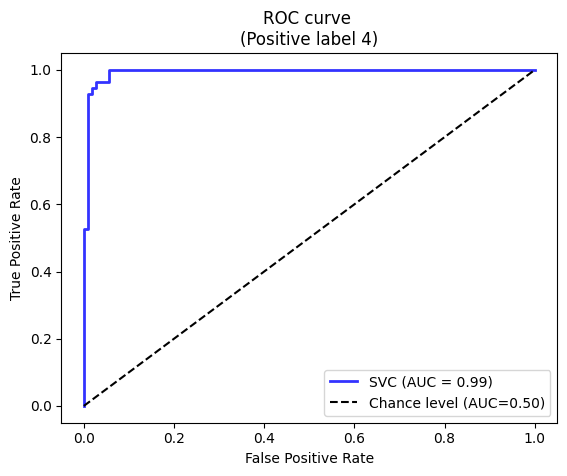

In [21]:
# ROC Curve with AUC
plt.figure(figsize=(10, 10), dpi=100)
svc_disp = RocCurveDisplay.from_estimator(svm_classifier, X_score, y_score, alpha=0.8, lw=2, color="b")  # ROC
plt.plot([0, 1], [0, 1], color='black', linestyle='--', label="Chance level (AUC=0.50)") # alternative chance
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC curve \n(Positive label {4})')

plt.legend(loc="lower right")
plt.show()

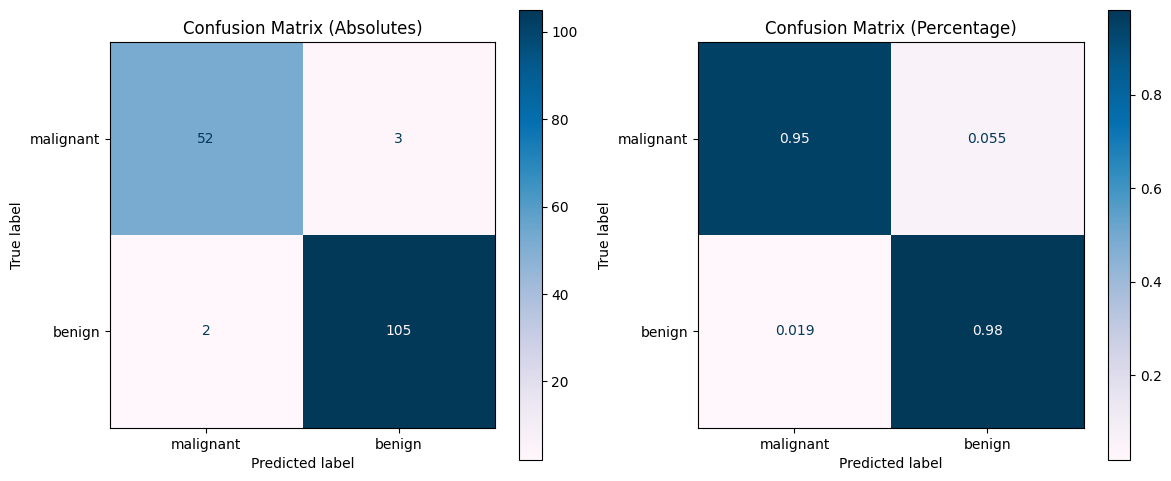

In [22]:
# Confusion Matrices
fig, axs = plt.subplots(1, 2, figsize=(12, 5))  # Create a figure with two subplots

color_map = "PuBu"

# Plot confusion matrix with absolute values
axs[0].set_title('Confusion Matrix (Absolutes)')
CM_absolute = ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix(y_score.tolist(), predicted, labels=[1,0]),
    display_labels=["malignant","benign"])
CM_absolute.plot(cmap=color_map, ax=axs[0])

# Plot confusion matrix with percentages
axs[1].set_title('Confusion Matrix (Percentage)')
conf_matrix = confusion_matrix(y_score, predicted, labels=[1,0])
conf_matrix_percentage = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
CM_percentage = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_percentage, display_labels=["malignant","benign"])
CM_percentage.plot(cmap=color_map, ax=axs[1])

plt.tight_layout()
plt.show()

## Random Forest

### Training

In [ ]:
K = 5

classifier = RandomForestClassifier(random_state=rs)
cv = KFold(n_splits=K, shuffle=True, random_state=rs)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Perform cross-validation with grid search for hyperparameter tuning
grid_search = GridSearchCV(classifier, param_grid, cv=cv, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_

# Train the model with the best hyperparameters
rf_classifier = grid_search.best_estimator_

# Evaluate the model
cv_scores = cross_val_score(rf_classifier, X_train, y_train, cv=cv)

# Print the results
print("The best cross-validated hyperparameters are the following:")
for key, value in best_params.items():
    print(f"{key}: {value}")

print("\nCV accuracy with tuned hyperparameters: %.2f%% (+/- %.2f%%)" % (cv_scores.mean() * 100, cv_scores.std() * 100))

The best cross-validated hyperparameters are the following:
bootstrap: False
max_depth: None
min_samples_leaf: 1
min_samples_split: 2
n_estimators: 200

CV accuracy with tuned hyperparameters: 88.56% (+/- 2.88%)


### Predictions and visualization

In [ ]:
predicted = rf_classifier.predict(X_score)

print(f"Test accuracy: {accuracy(predicted.tolist(), y_score.tolist())}")
print(f"Test sensitivity {sensitivity(predicted.tolist(), y_score.tolist())}")
print(f"Test specificity {specificity(predicted.tolist(), y_score.tolist())}")

Test accuracy: 0.864
Test sensitivity 0.764
Test specificity 0.916


<Figure size 1000x1000 with 0 Axes>

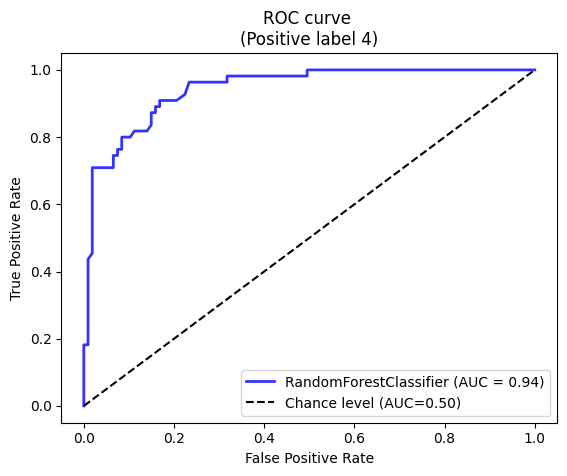

In [ ]:
# ROC Curve with AUC
plt.figure(figsize=(10, 10), dpi=100)
rf_disp = RocCurveDisplay.from_estimator(rf_classifier, X_score, y_score, alpha=0.8, lw=2, color="b")  # ROC
plt.plot([0, 1], [0, 1], color='black', linestyle='--', label="Chance level (AUC=0.50)") # alternative chance
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC curve \n(Positive label {4})')

plt.legend(loc="lower right")
plt.show()

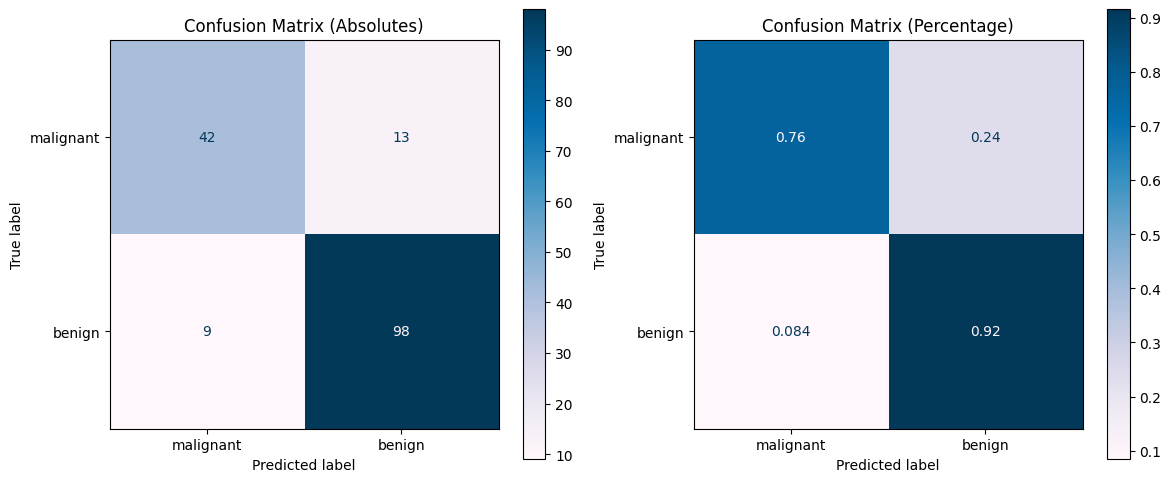

In [ ]:
# Confusion Matrices
fig, axs = plt.subplots(1, 2, figsize=(12, 5))  # Create a figure with two subplots

color_map = "PuBu"

# Plot confusion matrix with absolute values
axs[0].set_title('Confusion Matrix (Absolutes)')
CM_absolute = ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix(y_score.tolist(), predicted, labels=[1,0]),
    display_labels=["malignant","benign"])
CM_absolute.plot(cmap=color_map, ax=axs[0])

# Plot confusion matrix with percentages
axs[1].set_title('Confusion Matrix (Percentage)')
conf_matrix = confusion_matrix(y_score, predicted, labels=[1,0])
conf_matrix_percentage = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
CM_percentage = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_percentage, display_labels=["malignant","benign"])
CM_percentage.plot(cmap=color_map, ax=axs[1])

plt.tight_layout()
plt.show()

## MLP

### Training

In [ ]:
K = 5

classifier = MLPClassifier(random_state=rs, max_iter=1000)
cv = KFold(n_splits=K, shuffle=True, random_state=rs)

param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
    # (50,): A single hidden layer with 50 neurons.
    # (100,): A single hidden layer with 100 neurons.
    # (50, 50): Two hidden layers, each with 50 neurons.
    # (100, 50): Two hidden layers, the first with 100 neurons and the second with 50 neurons.
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.001, 0.01], #Strength of the L2 regularization term. The L2 regularization term is divided by the sample size when added to the loss.
    'learning_rate': ['constant', 'adaptive']
}

# Perform cross-validation with grid search for hyperparameter tuning
grid_search = GridSearchCV(classifier, param_grid, cv=cv, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_

# Train the model with the best hyperparameters
mlp_classifier = grid_search.best_estimator_

# Evaluate the model
cv_scores = cross_val_score(mlp_classifier, X_train, y_train, cv=cv)

# Print the results
print("The best cross-validated hyperparameters are the following:")
for key, value in best_params.items():
    print(f"{key}: {value}")

print("\nCV accuracy with tuned hyperparameters: %.2f%% (+/- %.2f%%)" % (cv_scores.mean() * 100, cv_scores.std() * 100))

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perce

The best cross-validated hyperparameters are the following:
activation: tanh
alpha: 0.0001
hidden_layer_sizes: (50, 50)
learning_rate: constant
solver: sgd

CV accuracy with tuned hyperparameters: 94.42% (+/- 2.83%)


### Predictions and visualization

In [ ]:
predicted = mlp_classifier.predict(X_score)

print(f"Test accuracy: {accuracy(predicted.tolist(), y_score.tolist())}")
print(f"Test sensitivity {sensitivity(predicted.tolist(), y_score.tolist())}")
print(f"Test specificity {specificity(predicted.tolist(), y_score.tolist())}")

Test accuracy: 0.957
Test sensitivity 0.909
Test specificity 0.981


<Figure size 1000x1000 with 0 Axes>

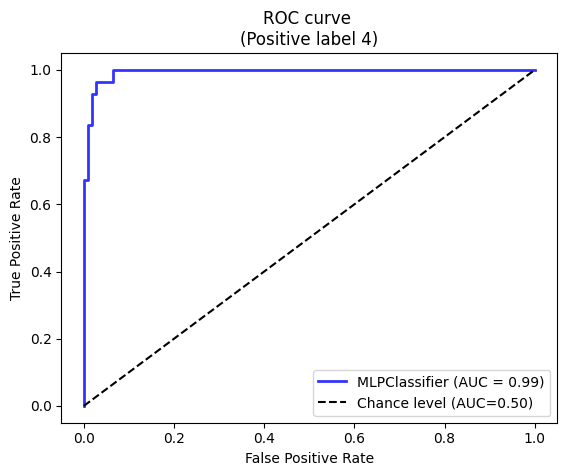

In [ ]:
# ROC Curve with AUC
plt.figure(figsize=(10, 10), dpi=100)
mlp_disp = RocCurveDisplay.from_estimator(mlp_classifier, X_score, y_score, alpha=0.8, lw=2, color="b")  # ROC
plt.plot([0, 1], [0, 1], color='black', linestyle='--', label="Chance level (AUC=0.50)") # alternative chance
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC curve \n(Positive label {4})')

plt.legend(loc="lower right")
plt.show()

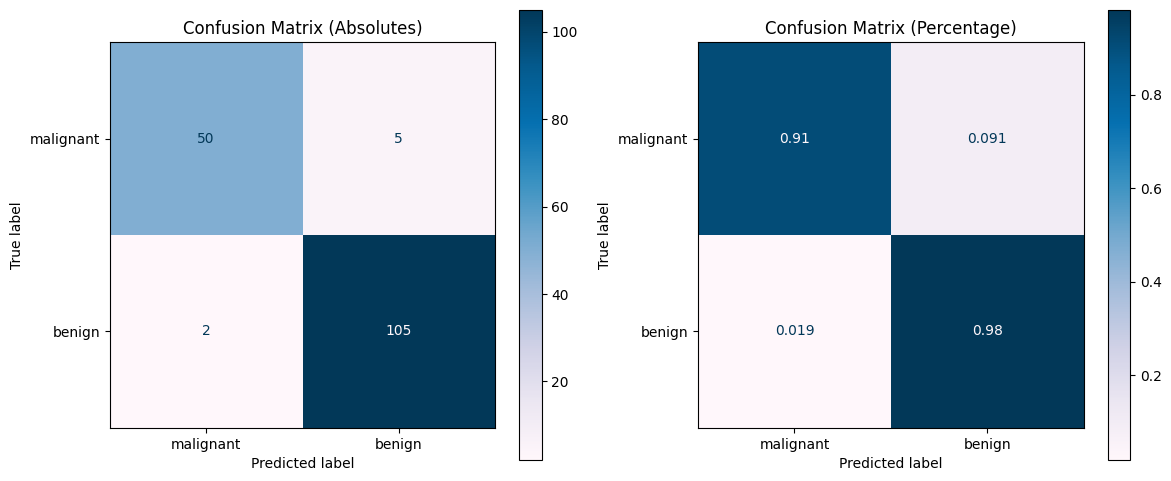

In [ ]:
# Confusion Matrices
fig, axs = plt.subplots(1, 2, figsize=(12, 5))  # Create a figure with two subplots

color_map = "PuBu"

# Plot confusion matrix with absolute values
axs[0].set_title('Confusion Matrix (Absolutes)')
CM_absolute = ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix(y_score.tolist(), predicted, labels=[1,0]),
    display_labels=["malignant","benign"])
CM_absolute.plot(cmap=color_map, ax=axs[0])

# Plot confusion matrix with percentages
axs[1].set_title('Confusion Matrix (Percentage)')
conf_matrix = confusion_matrix(y_score, predicted, labels=[1,0])
conf_matrix_percentage = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
CM_percentage = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_percentage, display_labels=["malignant","benign"])
CM_percentage.plot(cmap=color_map, ax=axs[1])

plt.tight_layout()
plt.show()

# Model trained on all data

The best performing model was the Support Vector Machine, let's train this model on the entire datsaset.

In [ ]:
malignant_features["tumor"] = 1
benign_features["tumor"] = 0

df = pd.concat([malignant_features, benign_features], ignore_index=True)
df = df.sample(frac=1).reset_index(drop=True) #this shuffles the dataset

In [ ]:
y = df["tumor"]
X = df.drop(['tumor'], axis=1)

rs = 42

In [ ]:
print(X.mean())
print(X.std())

original_firstorder_10Percentile          3.028922e+01
original_firstorder_90Percentile          1.093161e+02
original_firstorder_Energy                1.615635e+08
original_firstorder_Entropy               2.090308e+00
original_firstorder_InterquartileRange    4.019656e+01
                                              ...     
original_ngtdm_Busyness                   4.058975e+01
original_ngtdm_Coarseness                 3.573458e-03
original_ngtdm_Complexity                 6.339859e+00
original_ngtdm_Contrast                   1.012828e-02
original_ngtdm_Strength                   1.495329e-01
Length: 101, dtype: float64
original_firstorder_10Percentile          2.695498e+01
original_firstorder_90Percentile          4.044571e+01
original_firstorder_Energy                2.314119e+08
original_firstorder_Entropy               5.173416e-01
original_firstorder_InterquartileRange    1.768285e+01
                                              ...     
original_ngtdm_Busyness              

In [ ]:
# Save mean and standard deviation to CSV for future unseen data normalization
norm_df = pd.concat([X.mean(), X.std()], axis=1)
norm_df.to_csv('normalization_final.csv', index=False, header=['mean', 'std'])

In [ ]:
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns = X.columns)

In [ ]:
print(X.mean())
print(X.std())

original_firstorder_10Percentile          9.244980e-17
original_firstorder_90Percentile         -1.964558e-16
original_firstorder_Energy               -1.188640e-16
original_firstorder_Entropy              -2.410298e-16
original_firstorder_InterquartileRange    1.320711e-16
                                              ...     
original_ngtdm_Busyness                   8.584624e-17
original_ngtdm_Coarseness                 1.122605e-16
original_ngtdm_Complexity                -6.933735e-17
original_ngtdm_Contrast                  -7.759180e-17
original_ngtdm_Strength                  -6.603557e-17
Length: 101, dtype: float64
original_firstorder_10Percentile          1.000931
original_firstorder_90Percentile          1.000931
original_firstorder_Energy                1.000931
original_firstorder_Entropy               1.000931
original_firstorder_InterquartileRange    1.000931
                                            ...   
original_ngtdm_Busyness                   1.000931
original_n

Train

## SVM

Let's still employ a cv gridsearch approach in order to have an idea of the performances even without employing a test set

In [ ]:
K = 5

classifier = SVC(random_state=rs, probability=True)
cv = KFold(n_splits = K, shuffle = True, random_state = rs)

param_grid = {
    'C': [1, 5, 10, 20, 30],
    'kernel': ['linear', 'rbf', 'poly']
}

# Perform cross-validation with grid search for hyperparameter tuning
grid_search = GridSearchCV(classifier, param_grid, cv=cv, scoring='accuracy')
grid_search.fit(X, y)

# Get the best hyperparameters
best_params = grid_search.best_params_

# Train the model with the best hyperparameters
best_clf = grid_search.best_estimator_

# Evaluate the model
cv_scores = cross_val_score(best_clf, X, y, cv=cv)
#print(cv_scores)

# Print the results
print("The best cross-validated hyperparameters are the following:")
for key, value in best_params.items():
    print(f"{key}: {value}")

print("\n CV accuracy with tuned hyperparameters: %.2f%% (+/- %.2f%%)" % (cv_scores.mean() * 100, cv_scores.std() * 100))

The best cross-validated hyperparameters are the following:
C: 1
kernel: linear

 CV accuracy with tuned hyperparameters: 95.91% (+/- 1.25%)


The optimal hyperparameters slightly changed with the increased train set. However, the cross validated performances are similar. Alternatevly, we could also train the less performing models on the entire dataset and look for improvements.

## RF

In [ ]:
K = 5

classifier = RandomForestClassifier(random_state=rs)
cv = KFold(n_splits=K, shuffle=True, random_state=rs)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Perform cross-validation with grid search for hyperparameter tuning
grid_search = GridSearchCV(classifier, param_grid, cv=cv, scoring='accuracy')
grid_search.fit(X, y)

# Get the best hyperparameters
best_params = grid_search.best_params_

# Train the model with the best hyperparameters
best_clf = grid_search.best_estimator_

# Evaluate the model
cv_scores = cross_val_score(best_clf, X, y, cv=cv)

# Print the results
print("The best cross-validated hyperparameters are the following:")
for key, value in best_params.items():
    print(f"{key}: {value}")

print("\nCV accuracy with tuned hyperparameters: %.2f%% (+/- %.2f%%)" % (cv_scores.mean() * 100, cv_scores.std() * 100))

## MLP

In [ ]:
K = 5

classifier = MLPClassifier(random_state=rs, max_iter=1000)
cv = KFold(n_splits=K, shuffle=True, random_state=rs)

param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
    # (50,): A single hidden layer with 50 neurons.
    # (100,): A single hidden layer with 100 neurons.
    # (50, 50): Two hidden layers, each with 50 neurons.
    # (100, 50): Two hidden layers, the first with 100 neurons and the second with 50 neurons.
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.001, 0.01], #Strength of the L2 regularization term. The L2 regularization term is divided by the sample size when added to the loss.
    'learning_rate': ['constant', 'adaptive']
}

# Perform cross-validation with grid search for hyperparameter tuning
grid_search = GridSearchCV(classifier, param_grid, cv=cv, scoring='accuracy')
grid_search.fit(X, y)

# Get the best hyperparameters
best_params = grid_search.best_params_

# Train the model with the best hyperparameters
best_clf = grid_search.best_estimator_

# Evaluate the model
cv_scores = cross_val_score(best_clf, X, y, cv=cv)

# Print the results
print("The best cross-validated hyperparameters are the following:")
for key, value in best_params.items():
    print(f"{key}: {value}")

print("\nCV accuracy with tuned hyperparameters: %.2f%% (+/- %.2f%%)" % (cv_scores.mean() * 100, cv_scores.std() * 100))



## Save the model

In [ ]:
import pickle

save_model_name = 'svm_all.pkl'
with open(save_model_name,'wb') as f:
    pickle.dump(best_clf,f)

In [ ]:
from joblib import dump

# Save model
dump(best_clf, 'svm_final.joblib')


['svm_final.joblib']